In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from matplotlib.dates import DateFormatter
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
df=pd.read_csv('DNI_hr.csv')
df = df[["Date","Direct Normal [W/m^2]"]]
df["Date"] = pd.to_datetime(df["Date"])
df.set_index('Date', inplace=True)
df

,Direct Normal [W/m^2]
Date,
2008-06-01 00:00:00,0.000000
2008-06-01 01:00:00,0.000000
2008-06-01 02:00:00,0.000000
2008-06-01 03:00:00,0.000000
2008-06-01 04:00:00,12.084972
...,...
2013-12-31 19:00:00,0.000000
2013-12-31 20:00:00,0.000000
2013-12-31 21:00:00,0.000000


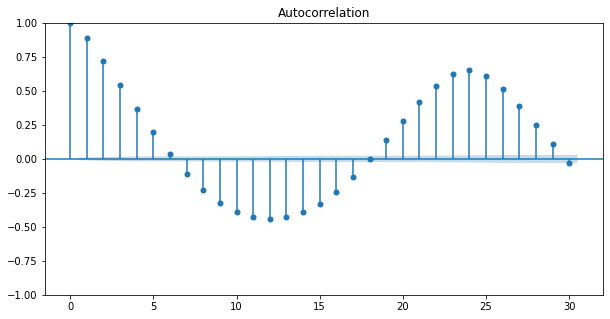

In [3]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(df['Direct Normal [W/m^2]'], lags=30)

fig = plt.gcf()
fig.set_size_inches(10,5)
plt.show()

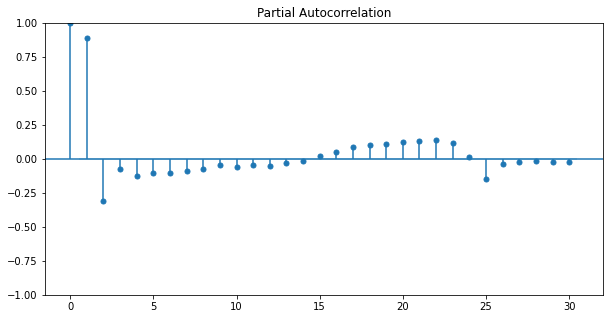

In [4]:
plot_pacf(df['Direct Normal [W/m^2]'], lags=30)
fig = plt.gcf()
fig.set_size_inches(10,5)
plt.show()

In [5]:
from datetime import timedelta
train_end = datetime(2013,12,30, 23, 0)
test_end = datetime(2013,12,31,23,0)
train_data = df[:train_end]
test_data = df[train_end + timedelta(hours=1):test_end]

In [6]:
ps = range(0, 5, 1)
qs = range(0, 5, 1)

order_list = list(product(ps, qs))

In [7]:
from typing import Union

def optimize_ARMA(endog: Union[pd.Series, list], order_list: list) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(endog, order=(order[0], 0, order[1]), simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [8]:
result_df = optimize_ARMA(train_data['Direct Normal [W/m^2]'], order_list)
result_df

  0%|          | 0/25 [00:00<?, ?it/s]

,"(p,q)",AIC
0,"(3, 4)",208.499178
1,"(3, 3)",632189.449220
2,"(4, 2)",632424.162678
3,"(4, 3)",632728.551092
4,"(2, 4)",636560.242610
5,"(4, 1)",636607.508647
6,"(2, 3)",636624.449571
7,"(3, 2)",636661.763659
8,"(4, 4)",636693.045892
9,"(2, 2)",636711.470157


In [18]:
model= SARIMAX(train_data['Direct Normal [W/m^2]'], order=(3,0,4),simple_differencing=False)
model_fit = model.fit(disp=False)

print(model_fit.summary())

                                 SARIMAX Results                                 
Dep. Variable:     Direct Normal [W/m^2]   No. Observations:                48936
Model:                  SARIMAX(3, 0, 4)   Log Likelihood                 -96.250
Date:                   Tue, 30 Jul 2024   AIC                            208.499
Time:                           20:48:27   BIC                            278.885
Sample:                       06-01-2008   HQIC                           230.569
                            - 12-30-2013                                         
Covariance Type:                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          3.0000   8.83e-10    3.4e+09      0.000       3.000       3.000
ar.L2         -3.0000   8.48e-10  -3.54e+09      0.000      -3.000      -3.000
ar.L3          1.0000   8.13

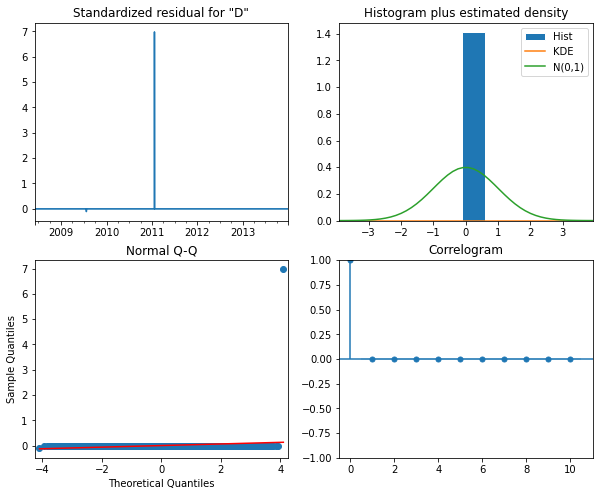

In [19]:
model_fit.plot_diagnostics(figsize=(10, 8));

In [20]:
model1= SARIMAX(train_data['Direct Normal [W/m^2]'], order=(3,0,3),simple_differencing=False)
model1_fit = model1.fit(disp=False)

print(model1_fit.summary())

                                 SARIMAX Results                                 
Dep. Variable:     Direct Normal [W/m^2]   No. Observations:                48936
Model:                  SARIMAX(3, 0, 3)   Log Likelihood             -316087.725
Date:                   Tue, 30 Jul 2024   AIC                         632189.449
Time:                           20:51:11   BIC                         632251.037
Sample:                       06-01-2008   HQIC                        632208.761
                            - 12-30-2013                                         
Covariance Type:                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          2.8293      0.003   1101.731      0.000       2.824       2.834
ar.L2         -2.7330      0.005   -547.930      0.000      -2.743      -2.723
ar.L3          0.8976      0

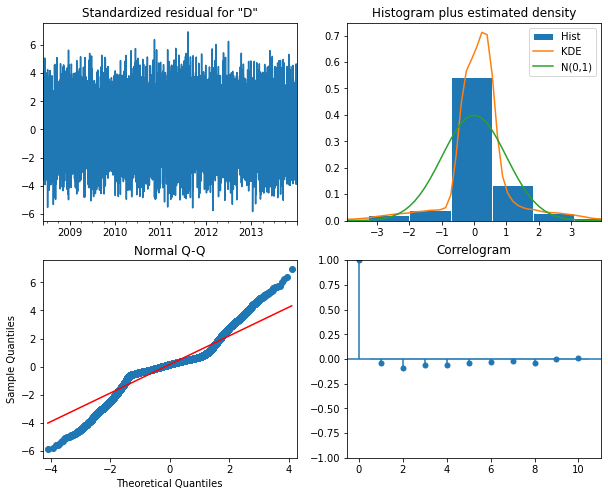

In [22]:
model1_fit.plot_diagnostics(figsize=(10, 8));

In [26]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int) -> list:
    
    total_len = train_len + horizon
    end_idx = train_len
    
    
    pred_ARIMA = []

    for i in range(train_len, total_len, window):
        model = SARIMAX(df[:i], order=(3,0,3))
        model_fit = model.fit(disp=False)
        predictions = model_fit.get_prediction(0, i + window - 1)
        rol_pred = predictions.predicted_mean.iloc[-window:]
        pred_ARIMA.extend(rol_pred)

    return pred_ARIMA

In [27]:
train_len= len(train_data)
horizon = len(test_data)
window = 1


pred_ARIMA = rolling_forecast(df, train_len, horizon,window)

In [32]:
print("Root Mean Squared Error:", np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 170.48193372328242


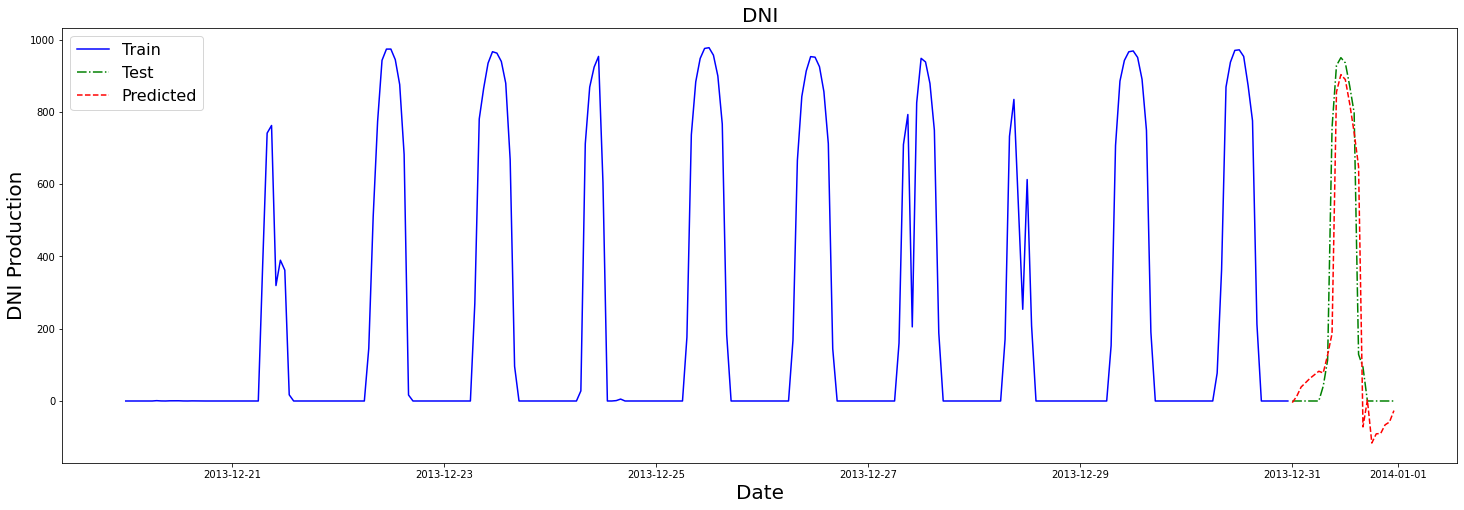

In [33]:
#plot prediction
start_date = datetime(2013,12,20)
end_date = datetime(2013,12,30, 23, 0)
lim_train_data = train_data[start_date:end_date]

plt.figure(figsize=(25,8))

plt.plot(lim_train_data,'b-', label='Train')
plt.plot(test_data['Direct Normal [W/m^2]'],'g-.', label='Test')
plt.plot(predictions, 'r--', label='Predicted')
plt.legend(loc=2,fontsize=16)

plt.title('DNI', fontsize=20)
plt.xlabel('Date',fontsize=20)
plt.ylabel('DNI Production', fontsize=20)
plt.show()


# Long term Forecast

In [44]:
from datetime import timedelta
train_end = datetime(2013,12,24, 23, 0)
test_end = datetime(2013,12,31,23,0)
train_data = df[:train_end]
test_data = df[train_end + timedelta(hours=1):test_end]

In [45]:
model1= SARIMAX(train_data['Direct Normal [W/m^2]'], order=(3,0,3),simple_differencing=False)
model1_fit = model1.fit(disp=False)

print(model1_fit.summary())

                                 SARIMAX Results                                 
Dep. Variable:     Direct Normal [W/m^2]   No. Observations:                48792
Model:                  SARIMAX(3, 0, 3)   Log Likelihood             -315225.415
Date:                   Fri, 02 Aug 2024   AIC                         630464.830
Time:                           22:38:26   BIC                         630526.397
Sample:                       06-01-2008   HQIC                        630484.138
                            - 12-24-2013                                         
Covariance Type:                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          2.8435      0.002   1333.574      0.000       2.839       2.848
ar.L2         -2.7540      0.004   -671.841      0.000      -2.762      -2.746
ar.L3          0.9084      0

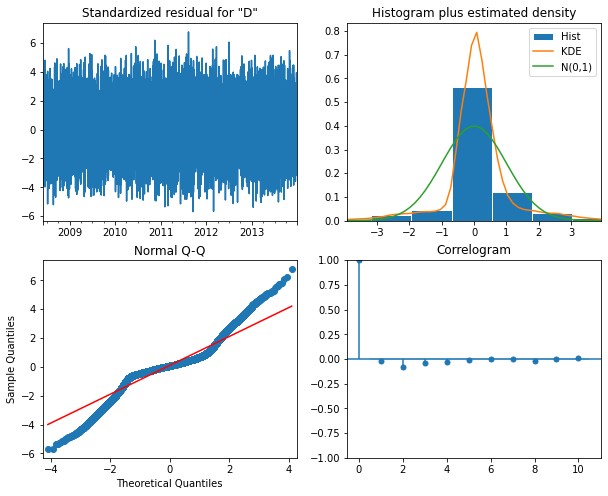

In [46]:
model1_fit.plot_diagnostics(figsize=(10, 8));

In [47]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int) -> list:
    
    total_len = train_len + horizon
    end_idx = train_len
    
    
    pred_ARIMA = []

    for i in range(train_len, total_len, window):
        model = SARIMAX(df[:i], order=(3,0,3))
        model_fit = model.fit(disp=False)
        predictions = model_fit.get_prediction(0, i + window - 1)
        rol_pred = predictions.predicted_mean.iloc[-window:]
        pred_ARIMA.extend(rol_pred)

    return pred_ARIMA

In [48]:
train_len= len(train_data)
horizon = len(test_data)
window = 1


pred_ARIMA = rolling_forecast(df, train_len, horizon,window)

In [49]:
predictions = pd.Series(pred_ARIMA, index=test_data.index)
residuals = test_data['Direct Normal [W/m^2]'] - predictions
print("Root Mean Squared Error:", np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 167.75657945721292


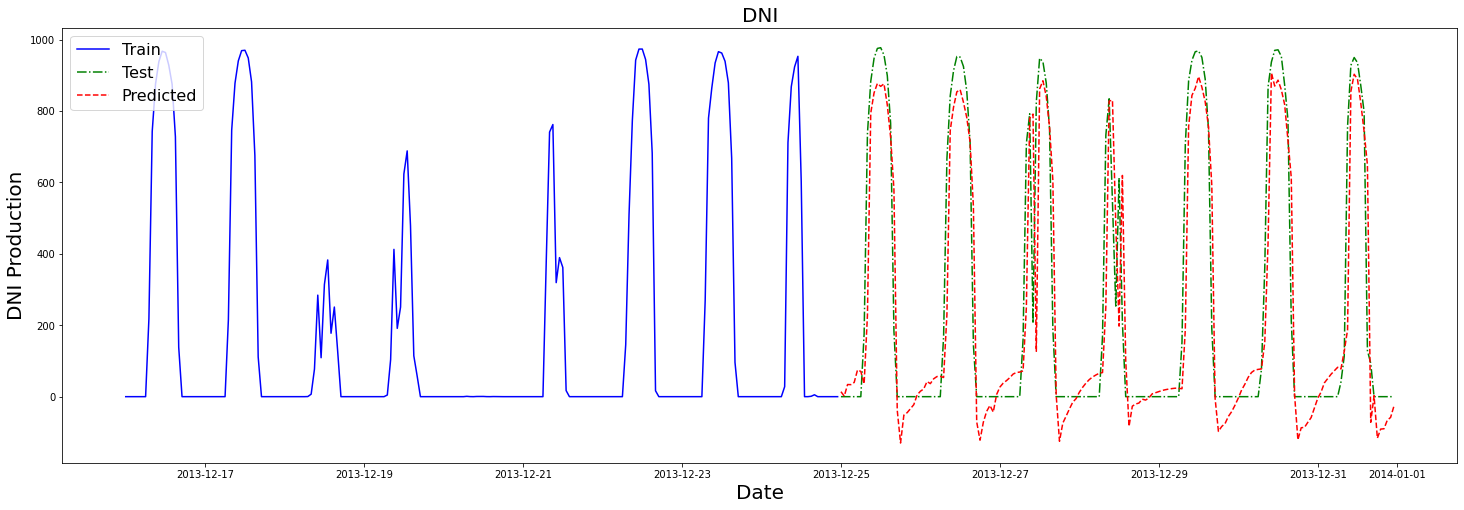

In [50]:
#plot prediction
start_date = datetime(2013,12,16)
end_date = datetime(2013,12,24, 23, 0)
lim_train_data = train_data[start_date:end_date]

plt.figure(figsize=(25,8))

plt.plot(lim_train_data,'b-', label='Train')
plt.plot(test_data['Direct Normal [W/m^2]'],'g-.', label='Test')
plt.plot(predictions, 'r--', label='Predicted')
plt.legend(loc=2,fontsize=16)

plt.title('DNI', fontsize=20)
plt.xlabel('Date',fontsize=20)
plt.ylabel('DNI Production', fontsize=20)
plt.show()
